#### 230701
- Curious to see what we can do with some ML algorthms and the Metabolon data
- First thought is to see if we can identify metabolites that are best at discriminating between:
    - Exercise versus sedentary samples
    - Vehicle vs 2HB vs DEG
    - Red vs white gastrocnemius

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import KFold
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder


#### Data Organization
- load data files
- fix chemical names
- select chemicals of interest (start with all named chemicals)
- drop duplicate chemical columns, happens in a few rare cases
- deal with NAs


In [3]:
path = '/Users/brennanwadsworth/Library/CloudStorage/OneDrive-KI.SE/Documents/BJW Experiments/BJW0037_Metabolon 2HB and exercise/UCAM-01-22-VW+/'
muscle_file = 'UCAM-01-22VW+ MUSCLE DATA TABLES'
serum_file = 'UCAM-01-22VW SERUM DATA TABLE'
# metabolite data
serum_df = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Peak Area Data' )
serum_df = serum_df.set_index('PARENT_SAMPLE_NAME')
muscle_df = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Peak Area Data' )
muscle_df = muscle_df.set_index('PARENT_SAMPLE_NAME')
# chemical meta data and named chemicals
muscle_chemicals = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Chemical Annotation' )
serum_chemicals = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Chemical Annotation' )
sel_chemicals = pd.read_excel(f'{path}selectmetabolites.xlsx',sheet_name='SERUM_named' )
# sample metadata
serum_samples = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Sample Meta Data' )
muscle_samples = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Sample Meta Data' )
print(muscle_df.shape,'\n', serum_df.shape,'\n',sel_chemicals.shape)

(72, 845) 
 (36, 1071) 
 (953, 5)


In [4]:
import re

def fix_chemicals (df_col):
    # goal is to remove all non alpha characters from chemical names so that they do not cause an error in the ANOVA calculation
    # input a dataframe and then column containing the chemicals
    # return a list of new column names to be assigned to a new column in the df
    pattern = r'[0-9]'
    name = list()
    for chem in df_col:
        new_str = re.sub(r'[\W_]', '', chem)
        new_str = re.sub(pattern,"",new_str)
        name.append(new_str)
    return name

muscle_chemicals['NEW_NAME'] = fix_chemicals(muscle_chemicals.PLOT_NAME)
serum_chemicals['NEW_NAME'] = fix_chemicals(serum_chemicals.PLOT_NAME)
sel_chemicals['NEW_NAME'] = fix_chemicals(sel_chemicals.PLOT_NAME)
sel_chemicals['NEW_UNIQUE_NAME'] = fix_chemicals(sel_chemicals.UNIQUE_NAME)

muscle_chemicals.to_csv('muscle_chemicals.csv')
serum_chemicals.to_csv('serum_chemicals.csv')


In [5]:
serum_df.columns = serum_chemicals.NEW_NAME
muscle_df.columns = muscle_chemicals.NEW_NAME
# df.columns = sel_chemicals.NEW_UNIQUE_NAME

# select chemicals of interest
muscle_sel = muscle_df.copy().loc[:,muscle_df.columns.isin(sel_chemicals.NEW_NAME)]
serum_sel = serum_df.copy().loc[:,serum_df.columns.isin(sel_chemicals.NEW_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)

(72, 620) 
 (36, 953)


In [6]:
# drop duplicated columns - these are all metabolites we are not interested in
dup = muscle_sel.columns[muscle_sel.columns.duplicated()]
muscle_sel = muscle_sel.drop(dup,axis=1)
dup = serum_sel.columns[serum_sel.columns.duplicated()]
serum_sel = serum_sel.drop(dup,axis=1)

In [7]:
# drop columns with at least half NA values
muscle_na = muscle_sel.dropna(axis=1,thresh=36)
serum_na = serum_sel.dropna(axis=1,thresh=18)
print(f'removed {serum_sel.shape[1] - serum_na.shape[1]} columns in serum file and {muscle_sel.shape[1] - muscle_na.shape[1]} in muscle')

removed 15 columns in serum file and 13 in muscle


In [8]:
# add group column, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
muscle_na.loc[:,'Group'] = muscle_samples.set_index("PARENT_SAMPLE_NAME").loc[:,'GROUP_NAME']
muscle_na.loc[:,'Tx'] = muscle_na.Group.str[0]
muscle_na.loc[:,'Ex'] = muscle_na.Group.str[1]
muscle_na.loc[:,"Tissue"] = muscle_samples.set_index("PARENT_SAMPLE_NAME").loc[:,"GASTROCNEMIUS"].str[0]
serum_na.loc[:,'Group'] = serum_samples.set_index("PARENT_SAMPLE_NAME").loc[:,'GROUP_NAME']
serum_na.loc[:,'Tx'] = serum_na.Group.str[0]
serum_na.loc[:,'Ex'] = serum_na.Group.str[1]
serum_na.loc[:,"Tissue"] = "S"

/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_98975/1702424123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_na.loc[:,'Group'] = muscle_samples.set_index("PARENT_SAMPLE_NAME").loc[:,'GROUP_NAME']
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_98975/1702424123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_na.loc[:,'Tx'] = muscle_na.Group.str[0]
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_98975/1702424123.py:4: SettingWithCopyWarning: 
A value 

In [9]:
# impute based on group values
def impute_by_group(df,grouping_col):
    # calcluate group values
    grouped = df.groupby(grouping_col) # organize data by groups
    holder_df = pd.DataFrame()
    for group in df[grouping_col].unique():
        new_df = grouped.get_group(group)
        new_df = new_df.fillna(new_df.select_dtypes(include=np.number).median())
        holder_df = pd.concat([holder_df,new_df])
    return holder_df


muscle_na = impute_by_group(muscle_na,'Group')
serum_na = impute_by_group(serum_na,'Group')
# drop columns that still contain NA, as these have an entire group where metabolite not detected
muscle_na = muscle_na.dropna(axis=1)
serum_na = serum_na.dropna(axis=1)


#### VO2 Correction
Plan to adjust for VO2 as we did in the June 2023 metabolomics analysis

In [10]:
# collect VO2 data and scale
vo2_df = pd.read_csv(f'{path}AVG_dVO2_18mmin.csv')
vo2_df = vo2_df.set_index('PARENT_SAMPLE_NAME')
vo2_df.drop(['MouseID','GASTROCNEMIUS','AUC','max_dVO2','max_VO2'],axis=1,inplace=True)
vo2_df


,avg_dVO2,avg_VO2
PARENT_SAMPLE_NAME,,
UCAM-55688,323.59720,4850.263889
UCAM-55724,173.27220,4449.938889
UCAM-55694,411.77640,4875.219444
UCAM-55730,408.03890,5322.058824
UCAM-55700,82.33889,5278.672222
...,...,...
UCAM-55659,0.00000,4057.291667
UCAM-55665,0.00000,3863.166667
UCAM-55671,0.00000,5040.875000


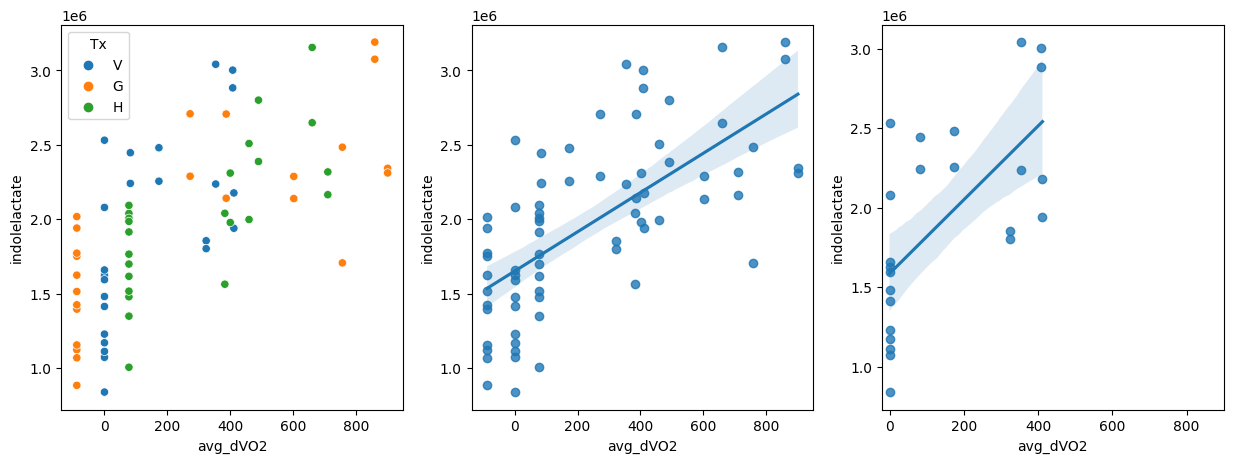

In [11]:
figure, axis = plt.subplots(1,3,figsize=(15,5))
ax1 = sns.scatterplot(data=pd.concat([muscle_na,vo2_df],axis=1),x='avg_dVO2',y='indolelactate',hue='Tx', ax = axis[0])
ax2 = sns.regplot(data=pd.concat([muscle_na,vo2_df],axis=1),x='avg_dVO2',y='indolelactate', ax = axis[1])
ax3 = sns.regplot(data=pd.concat([muscle_na[muscle_na.Tx == 'V'],vo2_df],axis=1),x='avg_dVO2',y='indolelactate', ax = axis[2])
ax3.set(xlim=(None, 900))
plt.show()

The above shows an example of an exercise-induced metabolite, indolelactate, which shows reduced production per-VO2 in both DEG and 2HB treated mice. That is, indolelactate increases with VO2, but at a lower rate in the treated mice. From this we can see:
- if we regress on the entire dataset for the VO2 adjustment, Veh mice will show high indole lactate and treated mice will show low or close-to-predicted indolelactate.
- if we regress on only the veh, then the opposite occurs; veh mice will appear close to predicted, treated mice will show up as below predicted.
In conclusion, it should not matter which method we choose. May as well regress on all data to have greater confidence in prediction and reduce error.

In [12]:
# build a function to conduct the VO2 adjustment
# inputs are the metabolite data frame, the vo2 data frame, and list of the covariates to use
def vo2_adj(met_df,vo2_df,covars):
    feature_col = met_df.select_dtypes(include=np.number).columns
    adj_df = pd.DataFrame(columns=met_df[feature_col].columns) # frame for holding adjusted values
    df = pd.concat([met_df,vo2_df],axis=1,join='inner')
    for met in adj_df.columns:
        # print(met) # for tracking progress in loop
        # C(Group) tells the model to expect a categorical variable
        model = ols(formula=f'{met} ~ {covars[0]} + {covars[1]}', data = df).fit()
        adj_df[met] = model.resid + model.params[0]
    adj_df = pd.concat([adj_df,met_df.select_dtypes(include=object)],axis=1)
    return adj_df


In [13]:
muscle_adj = vo2_adj(muscle_na,vo2_df,['avg_dVO2','avg_VO2'])
serum_adj = vo2_adj(serum_na,vo2_df,['avg_dVO2','avg_VO2'])

#### Data Normalization
- FWN strategy, compare:
    - standard scaler
    - shapiro test,
    - if not normal then power transform

In [14]:
def fwn(df):
    num_df = df.select_dtypes(include=np.number) # values to be normalized
    obj_df = df.select_dtypes(include=object) # store categorical variables in separate frame and concatenate later
    count = 0
    pwr_transformer = PowerTransformer(method = 'yeo-johnson')
    std_scaler = StandardScaler()
    scaled = pd.DataFrame(std_scaler.fit_transform(num_df))
    transformed = pd.DataFrame(pwr_transformer.fit_transform(num_df))
    pwr_index = []
    for col in scaled.columns:
        shap_stat = shapiro(scaled.iloc[:,col])[0]
        if shap_stat >= 0.80:
            num_df.iloc[:,col] = scaled.iloc[:,col].values
            pwr_index.append(0)
        else:
            pwr_index.append(1)
            count += 1
            num_df.iloc[:,col] = transformed.iloc[:,col].values
    print(f"Number of columns power transformed: {count}, {100*round(count/len(num_df.columns),2)}%")
    merge_df = pd.concat([num_df,obj_df],axis=1) # re-merge normalized numeric columns and categorical columns
    return merge_df, pwr_index

In [15]:
muscle_fwn, muscle_index = fwn(muscle_adj)
serum_fwn, serum_index = fwn(serum_adj)

/Users/brennanwadsworth/VSCodeProjects/Metabolon_venv.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Number of columns power transformed: 85, 16.0%
Number of columns power transformed: 66, 8.0%


#### Encoding categorical data

In [16]:
# merge muscle and serum df into one, limited to metabolites present in both
fwn_df = pd.concat([muscle_fwn,serum_fwn],axis=0,join='inner')
le = LabelEncoder()
fwn_df.loc[:,'Tx'] = le.fit_transform(fwn_df.Tx) # outputs in alphabetical order, i.e. G = 0, H = 1, V = 2
fwn_df.loc[:,'Ex'] = le.fit_transform(fwn_df.Ex) # R = 0, S = 1
fwn_df.loc[:,'Tissue'] = le.fit_transform(fwn_df.Tissue) # R = 0, S = 1, W = 2
red_fwn = fwn_df[fwn_df.Tissue == 0]
white_fwn = fwn_df[fwn_df.Tissue == 2]

#### Data Visualization  - PCA

In [17]:
sel_df = red_fwn
features = sel_df.select_dtypes(include=np.number)
label = sel_df.Tx

In [18]:
pca = PCA(n_components=2) # number of features that we want to reduce down to
# for visualization purposes, best to choose two or three components. Can plot out feature importance to see how much variance each
#   component explains, and see how important it is to have more components or not
pca_features = pca.fit_transform(features)
print('Shape before PCA: ', features.shape)
print('Shape after PCA: ', pca_features.shape)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])

Shape before PCA:  (36, 497)
Shape after PCA:  (36, 2)


In [19]:
# add back label (Group) column
pca_df = pd.concat([pca_df,label.reset_index().drop('PARENT_SAMPLE_NAME',axis=1)],axis=1)

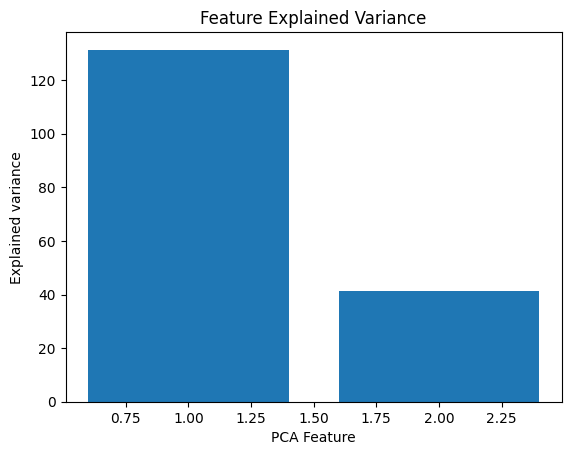

In [20]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

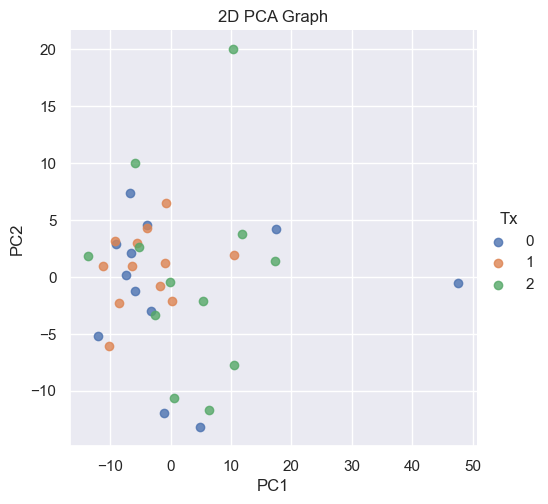

In [21]:
sns.set()
 
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    hue='Tx', 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()

#### Model building
going to use a Gradient Boosted decision forest through tensor flow, and then we watn to identify feature importances for discriminating between exercise and treatment groups adn tissues

In [22]:
kf = KFold(n_splits=5,shuffle=True)

# Create list of ids for the creation of oof dataframe.
ID_LIST = fwn_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros(len(ID_LIST)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Tx"

In [23]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=red_fwn)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = fwn_df.iloc[train_index]
        valid_df = fwn_df.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        feature_col = [i for i in train_df.columns if i not in ['Group']]
        train_df = train_df[feature_col]
        valid_df = valid_df[feature_col]
        
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        gbdf = tfdf.keras.GradientBoostedTreesModel()
        gbdf.compile(metrics=["accuracy", "categorical_crossentropy"]) 
        
        # Train the model
        gbdf.fit(x=train_ds)
        
        # Store the model
        models[f"fold_{i+1}"] = gbdf
        
        
        # Predict OOF value for validation data
        predictions = gbdf.predict(x=valid_ds)
        # Store the predictions in oof dataframe
#        oof.loc[valid_ids, 0] = predict.flatten() 
        
        # Evaluate and store the metrics in respective dicts
#        evaluation = gbdf.evaluate(x=valid_ds)
#        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
#        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

##### Fold 1
Use /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmppbgbvfp8 as temporary training directory
Reading training dataset...


[WARNING 23-07-06 17:26:41.2526 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:26:41.2559 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:26:41.2559 CEST gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-06 17:26:41.336283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_453' with dtype double and shape [28]
	 [[{{node Placeholder/_453}}]]


Training dataset read in 0:00:11.882276. Found 28 examples.
Training model...
Model trained in 0:00:01.832137
Compiling model...


[INFO 23-07-06 17:26:54.8821 CEST kernel.cc:1242] Loading model from path /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmppbgbvfp8/model/ with prefix 6b135aa050b54c78
[INFO 23-07-06 17:26:54.9909 CEST quick_scorer_extended.cc:873] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 23-07-06 17:26:54.9916 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-06 17:26:54.9918 CEST kernel.cc:1074] Use fast generic engine
2023-07-06 17:26:55.086762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_60' with dtype double and shape [28]
	 [[{{node Placeholder/_60}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


2023-07-06 17:27:01.793147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [8]
	 [[{{node Placeholder/_11}}]]


1/1 [==============================] - 1s 1s/step
##### Fold 2
Use /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmpdo21naxy as temporary training directory
Reading training dataset...


[WARNING 23-07-06 17:27:03.7770 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:27:03.7770 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:27:03.7771 CEST gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-06 17:27:03.834011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_62' with dtype double and shape [29]
	 [[{{node Placeholder/_62}}]]


Training dataset read in 0:00:07.995607. Found 29 examples.
Training model...
Model trained in 0:00:13.478340
Compiling model...


[INFO 23-07-06 17:27:25.2462 CEST kernel.cc:1242] Loading model from path /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmpdo21naxy/model/ with prefix 1d26b6589a4e4279
[INFO 23-07-06 17:27:25.2572 CEST quick_scorer_extended.cc:873] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 23-07-06 17:27:25.2580 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-06 17:27:25.2583 CEST kernel.cc:1074] Use fast generic engine
2023-07-06 17:27:25.342978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_46' with dtype double and shape [29]
	 [[{{node Placeholder/_46}}]]


Model compiled.


2023-07-06 17:27:29.208716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_63' with dtype double and shape [7]
	 [[{{node Placeholder/_63}}]]


1/1 [==============================] - 1s 930ms/step
##### Fold 3
Use /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmp0rxckiqk as temporary training directory
Reading training dataset...


[WARNING 23-07-06 17:27:31.3402 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:27:31.3402 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:27:31.3403 CEST gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-06 17:27:31.401673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_361' with dtype double and shape [29]
	 [[{{node Placeholder/_361}}]]


Training dataset read in 0:00:06.592641. Found 29 examples.
Training model...
Model trained in 0:00:02.724046
Compiling model...


[INFO 23-07-06 17:27:40.6610 CEST kernel.cc:1242] Loading model from path /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmp0rxckiqk/model/ with prefix fd26291dd58841ea
[INFO 23-07-06 17:27:40.6632 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-06 17:27:40.6634 CEST kernel.cc:1074] Use fast generic engine
2023-07-06 17:27:40.723313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_318' with dtype double and shape [29]
	 [[{{node Placeholder/_318}}]]


Model compiled.


2023-07-06 17:27:45.086890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_244' with dtype double and shape [7]
	 [[{{node Placeholder/_244}}]]


1/1 [==============================] - 1s 1s/step
##### Fold 4
Use /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmpgqhzq_bb as temporary training directory
Reading training dataset...


[WARNING 23-07-06 17:27:47.0842 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:27:47.0842 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:27:47.0843 CEST gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-06 17:27:47.137083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_99' with dtype double and shape [29]
	 [[{{node Placeholder/_99}}]]


Training dataset read in 0:00:06.897247. Found 29 examples.
Training model...
Model trained in 0:00:01.617794
Compiling model...


[INFO 23-07-06 17:27:55.6040 CEST kernel.cc:1242] Loading model from path /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmpgqhzq_bb/model/ with prefix 728ae9a3120a42db
[INFO 23-07-06 17:27:55.6051 CEST quick_scorer_extended.cc:873] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 23-07-06 17:27:55.6053 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-06 17:27:55.6055 CEST kernel.cc:1074] Use fast generic engine
2023-07-06 17:27:55.667173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_75' with dtype double and shape [29]
	 [[{{node Placeholder/_75}}]]


Model compiled.


2023-07-06 17:27:59.961000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_60' with dtype double and shape [7]
	 [[{{node Placeholder/_60}}]]


1/1 [==============================] - 1s 967ms/step
##### Fold 5
Use /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmpzoqm_c_m as temporary training directory
Reading training dataset...


[WARNING 23-07-06 17:28:01.7093 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:28:01.7093 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-06 17:28:01.7093 CEST gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-06 17:28:01.755611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_164' with dtype double and shape [29]
	 [[{{node Placeholder/_164}}]]


Training dataset read in 0:00:06.495733. Found 29 examples.
Training model...
Model trained in 0:00:01.491237
Compiling model...


[INFO 23-07-06 17:28:09.7020 CEST kernel.cc:1242] Loading model from path /var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/tmpzoqm_c_m/model/ with prefix fcd44566318f48cd
[INFO 23-07-06 17:28:09.7031 CEST abstract_model.cc:1312] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-06 17:28:09.7033 CEST kernel.cc:1074] Use fast generic engine
2023-07-06 17:28:09.759995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_73' with dtype double and shape [29]
	 [[{{node Placeholder/_73}}]]


Model compiled.


2023-07-06 17:28:13.514236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_108' with dtype double and shape [7]
	 [[{{node Placeholder/_108}}]]


1/1 [==============================] - 1s 972ms/step


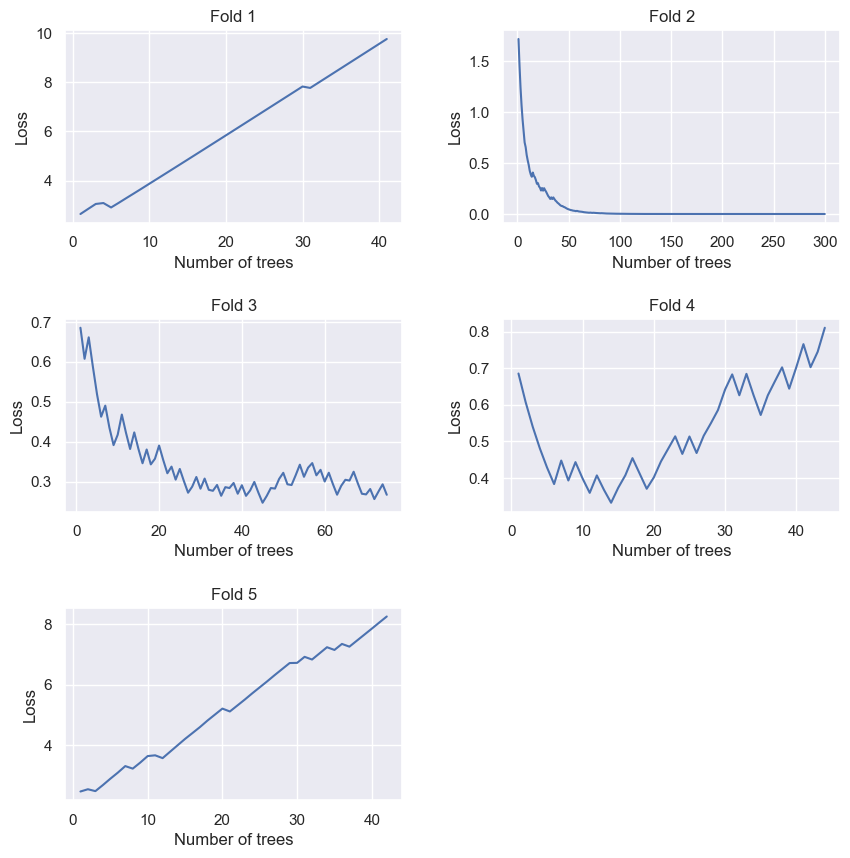

In [24]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss')

axis[2][1].set_visible(False)
plt.show()

In [25]:
inspector = models['fold_4'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


("pcresolsulfate" (1; #408), 18.1136462315917)
("methylcytidine" (1; #321), 2.798662707209587)
("adenine" (1; #66), 2.1766626462340355)
("cinnamoylglycine" (1; #123), 0.8179510049521923)
("pipecolate" (1; #425), 0.6991717368364334)
("NNNtrimethyllysine" (1; #10), 0.5645651742815971)


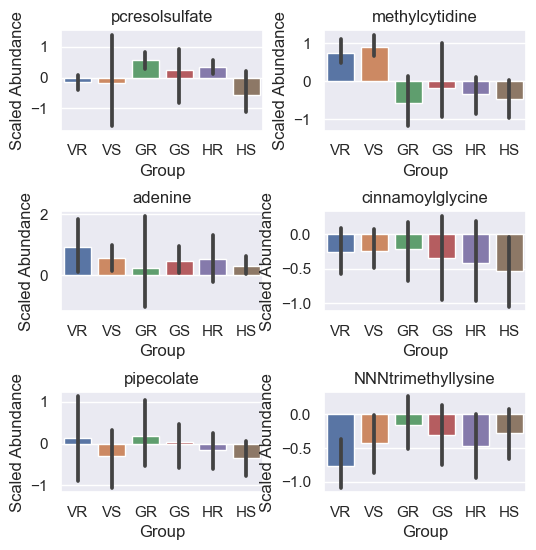

In [26]:
# Each line is: (feature name, (index of the feature), importance score)
scores = inspector.variable_importances()["SUM_SCORE"]

figure, axis = plt.subplots(3, 2, figsize=(6, 6))
plt.subplots_adjust(hspace=0.8, wspace=0.3)

for i, score in enumerate(scores[0:6]):
    print(score)
    row = i//2
    col = i % 2
    ax = sns.barplot(muscle_fwn[muscle_fwn.Tissue == 'R'], x = 'Group', y = score[0][0], ax = axis[row, col])
    ax.set_title(score[0][0])
    ax.set_xlabel('Group')
    ax.set_ylabel('Scaled Abundance')

plt.show()    

In [27]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("pcresolsulfate" (1; #408), 8.0),
 ("adenine" (1; #66), 3.0),
 ("methylcytidine" (1; #321), 3.0)]

In [28]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_NODES"]

[("pcresolsulfate" (1; #408), 8.0),
 ("adenine" (1; #66), 3.0),
 ("methylcytidine" (1; #321), 3.0),
 ("cinnamoylglycine" (1; #123), 2.0),
 ("myristoylpalmitoylGPC" (1; #342), 2.0),
 ("pipecolate" (1; #425), 2.0),
 ("NNNtrimethyllysine" (1; #10), 1.0),
 ("Nacetylasparagine" (1; #18), 1.0),
 ("caprylate" (1; #114), 1.0),
 ("dihomolinolenoylGPCnor" (1; #141), 1.0),
 ("enyloleoylGPEP" (1; #172), 1.0),
 ("enylpalmitoylarachidonoylGPEP" (1; #176), 1.0),
 ("ethylmalonate" (1; #194), 1.0),
 ("hydroxylysine" (1; #253), 1.0),
 ("imidazolelactate" (1; #267), 1.0),
 ("linolenatenorn" (1; #288), 1.0),
 ("linoleoyllinolenoylGPC" (1; #299), 1.0),
 ("malonate" (1; #304), 1.0),
 ("methionine" (1; #314), 1.0),
 ("myristoylarachidonoylGPC" (1; #340), 1.0),
 ("nonadecenoaten" (1; #348), 1.0),
 ("oleoylethanolamide" (1; #359), 1.0),
 ("palmitoylGPE" (1; #379), 1.0),
 ("palmitoyllinoleoylGPE" (1; #395), 1.0),
 ("phenyllactatePLA" (1; #418), 1.0),
 ("serotonin" (1; #442), 1.0),
 ("taurine" (1; #474), 1.0),
 

#### Confusion Matrix